# Supplementary Information: Holmes *et al.* 2017

# 1. Data cleaning, normalisation and quality assurance

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import scipy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Data import

Raw data was previously converted from two `Excel` files:

* `AH alldata 12082013.xlsx` was converted to `data/treatment_unix_endings.csv`
* `AH alldata expt1 flagged 05092013.xlsx` was converted to `data/control_unix_endings_flags.csv`

These describe microarray results for samples that underwent two treatments:

* *in vitro* growth only - **control** - `data/control_unix_endings_flags.csv`
* *in vitro* growth and plant passage - **treatment** - `data/treatment_unix_endings.csv`

We import these data into corresponding `treatment` and `control` dataframes, with the array probe systematic name as the index:

In [2]:
# read data
control = pd.read_csv('data/control_unix_endings_flags.csv', sep=',', skiprows=4, index_col=0)
treatment = pd.read_csv('data/treatment_unix_endings.csv', sep=',', skiprows=4, index_col=0)

We reduce the full dataset to only the raw intensity values, as `control_raw` and `treatment_raw`. In both runs, the mapping of experimental samples (*input* and *output*) across the three replicates is:

* replicate 1 *input* $\rightarrow$ `Raw`
* replicate 1 *output* $\rightarrow$ `Raw.1`
* replicate 2 *input* $\rightarrow$ `Raw.2`
* replicate 2 *output* $\rightarrow$ `Raw.3`
* replicate 3 *input* $\rightarrow$ `Raw.4`
* replicate 3 *output* $\rightarrow$ `Raw.5`

In [3]:
colnames_in = ['Raw', 'Raw.1', 'Raw.2', 'Raw.3', 'Raw.4', 'Raw.5']
colnames_out = ['input.1', 'output.1', 'input.2', 'output.2', 'input.3', 'output.3']

# reduce data to raw intensity values
control_raw = control[colnames_in]
control_raw.columns = colnames_out
treatment_raw = treatment[colnames_in]
treatment_raw.columns = colnames_out

### Correlation

We can inspect the extent of correlation between the datasets visually:

In [4]:
def corrfunc(x, y, **kws):
    r, _ = scipy.stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.3f}".format(r),
                xy=(.3, .5), size=15,
                xycoords=ax.transAxes)
    
def plot_correlation(data, title=None):
    g = sns.PairGrid(data)
    g.map_lower(plt.scatter)
    g.map_diag(sns.kdeplot, legend=False)
    g.map_upper(corrfunc)
    g.set(xticklabels=[])
    g.set(title=title or '')
    return g

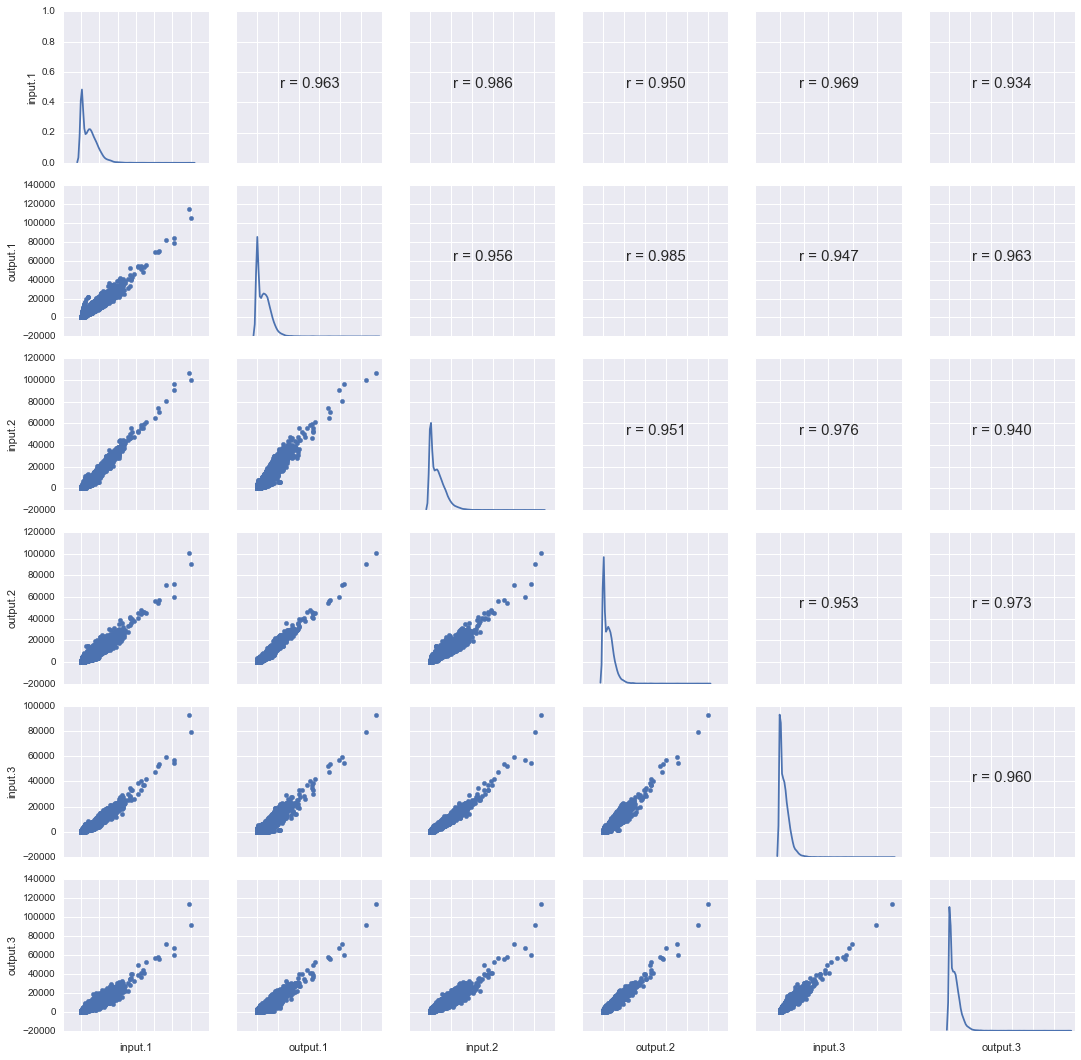

In [5]:
# plot control dataset correlation
plot_correlation(control_raw);

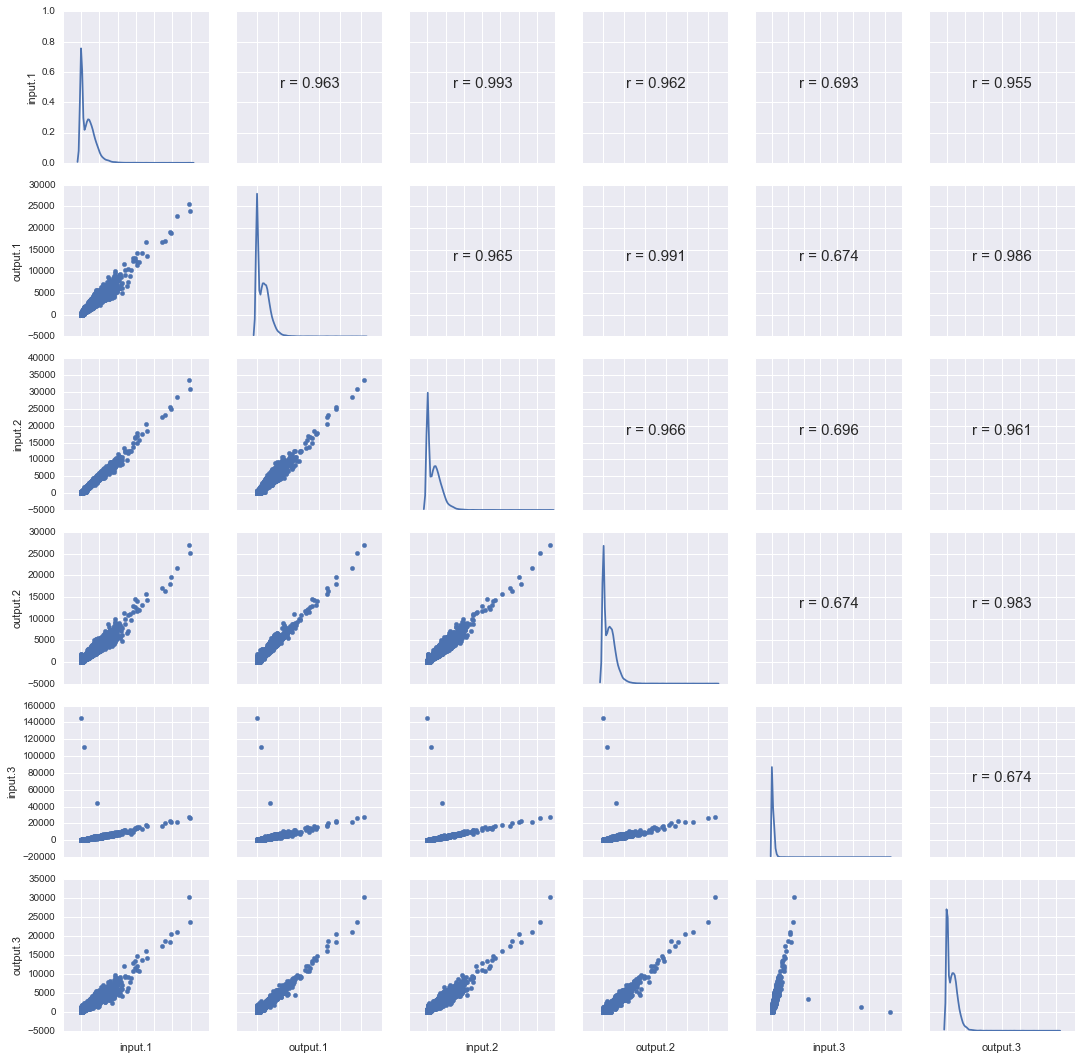

In [6]:
# plot control dataset correlation
plot_correlation(treatment_raw);

These plots indicate:

* the intensities of the control arrays are systematically larger than the treatment arrays, suggesting that the effects of noise may be proportionally greater for the treatment arrays
* the control arrays are good candidates for quantile normalisation (QN; $r > 0.93$, with similar density distributions)
* the treatment array `input.3` dataset is potentially problematic for , due to three datapoints with intensities greater than 40,000 units having large leverage.

We can identify the troublesome probes

In [7]:
# Select outlying treatment input.3 values
treatment_raw.loc[treatment_raw['input.3'] > 4e4]

,input.1,output.1,input.2,output.2,input.3,output.3
Systematic,,,,,,
A_07_P000070,4251.70600,3054.75400,3997.707000,3013.079000,44857.48,3283.400000
A_07_P061472,10.65405,4.49928,1.687277,3.855374,145625.60,8.290274
A_07_P052489,929.70990,1056.72400,987.524200,957.422400,110306.40,1327.634000


Without the influence of these three probes, the treatment datasets show good correlation, and strong similarity in distribution, so we are justified in using quantile normalisation.

In [8]:
# Pearson correlation coefficients for treatment data, excluding outliers
treatment_raw.loc[treatment_raw['input.3'] < 4e4].corr('pearson')

,input.1,output.1,input.2,output.2,input.3,output.3
input.1,1.000000,0.962793,0.993381,0.961499,0.987666,0.954562
output.1,0.962793,1.000000,0.964688,0.990921,0.960784,0.986433
input.2,0.993381,0.964688,1.000000,0.966287,0.992854,0.961277
output.2,0.961499,0.990921,0.966287,1.000000,0.961224,0.982820
input.3,0.987666,0.960784,0.992854,0.961224,1.000000,0.960038
output.3,0.954562,0.986433,0.961277,0.982820,0.960038,1.000000


In [9]:
# Spearman correlation coefficients for treatment data, including outliers
treatment_raw.corr('spearman')

,input.1,output.1,input.2,output.2,input.3,output.3
input.1,1.000000,0.974076,0.992560,0.967946,0.986361,0.959009
output.1,0.974076,1.000000,0.968833,0.985284,0.963805,0.972636
input.2,0.992560,0.968833,1.000000,0.969063,0.988809,0.955908
output.2,0.967946,0.985284,0.969063,1.000000,0.959092,0.968035
input.3,0.986361,0.963805,0.988809,0.959092,1.000000,0.961447
output.3,0.959009,0.972636,0.955908,0.968035,0.961447,1.000000


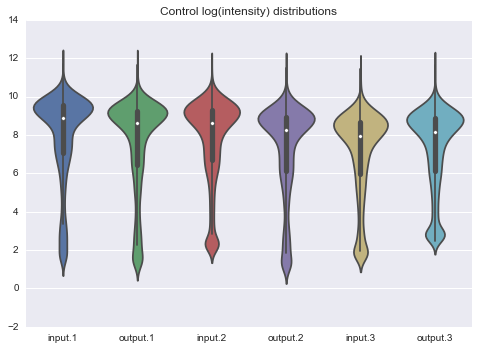

In [10]:
# Visualise control intensity distributions
g = sns.violinplot(log(control_raw))
g.set_title("Control log(intensity) distributions");

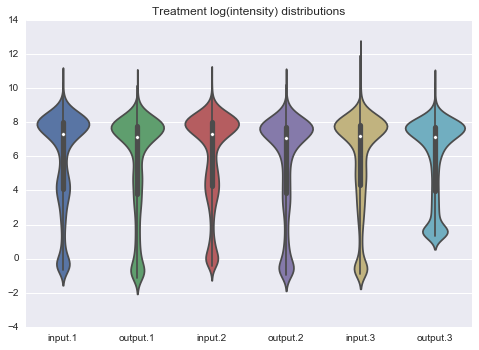

In [11]:
# Visualise treatment intensity distributions (with outliers)
g = sns.violinplot(log(treatment_raw))
g.set_title("Treatment log(intensity) distributions");

From these distributions it appears that treatment `output.3` appears to have a higher baseline signal than the other treatment arrays.

## Quantile normalisation

We have established that because the input and output arrays in both control and treatment conditions have strong correlation across all intensities and similar intensity distributions, we are justified in using quantile (mean) normalisation.

As we expect the overall effect on array signal to vary according to whether the sample was from the input (strong) or output (weak) set, and whether the sample came from the control or treatment pools, we divide the dataset into four components, and apply normalisation to four arrays independently, as subsets of the raw datasets `control_raw` and `treatment_raw`:

* `control_input`
* `control_output`
* `treatment_input`
* `treatment_output`

In [12]:
def quantile_norm(df, columns=None):
    """Normalise the columns of df to each have the same distribution"""
    df_matrix = df.as_matrix(columns=columns)
    quantiles = np.mean(np.sort(df_matrix, axis=0), axis=1)
    ranks = scipy.stats.mstats.rankdata(df_matrix, axis=0).astype(int) - 1
    norm_matrix = quantiles[ranks]
    return(pd.DataFrame(data=norm_matrix, index=df.index,
                        columns=columns or df.columns))

In [13]:
# Normalise inputs and outputs for control and treatment separately
control_input = quantile_norm(control_raw, columns=['input.1', 'input.2', 'input.3'])
control_output = quantile_norm(control_raw, columns=['output.1', 'output.2', 'output.3'])
treatment_input = quantile_norm(treatment_raw, columns=['input.1', 'input.2', 'input.3'])
treatment_output = quantile_norm(treatment_raw, columns=['output.1', 'output.2', 'output.3'])

We can visualise the effect this has on the distributions:

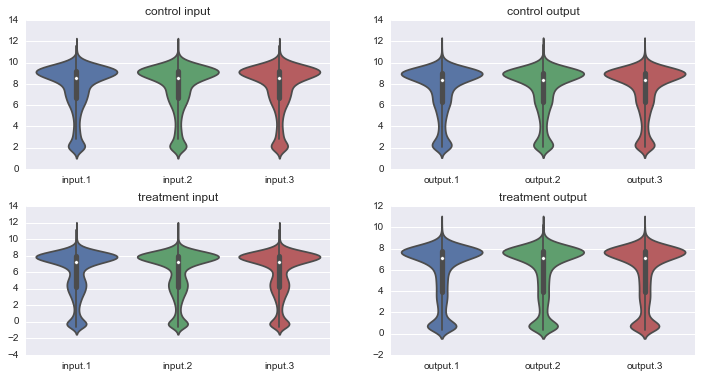

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
fig.subplots_adjust(hspace=.25)
axes = axes.ravel()
for ttl, arr, ax in zip(("control input", "control output", "treatment input", "treatment output"),
                        (control_input, control_output, treatment_input, treatment_output),
                        axes):
    ax.set_title(ttl)
    sns.violinplot(log(arr), ax=ax)

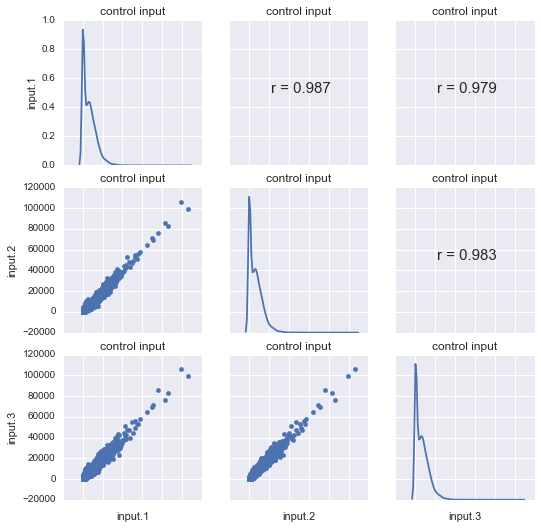

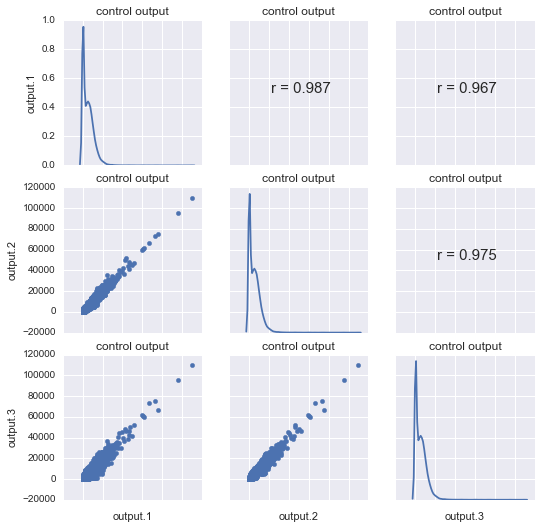

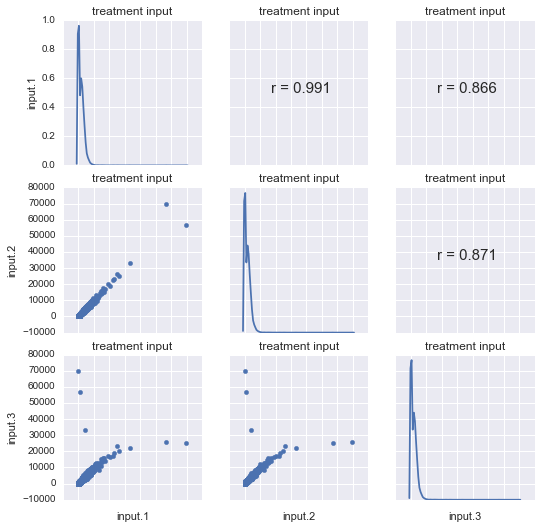

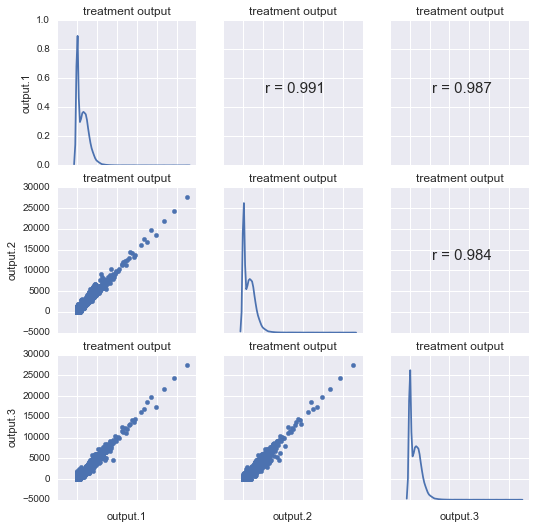

In [15]:
for ttl, arr in zip(("control input", "control output", "treatment input", "treatment output"),
                    (control_input, control_output, treatment_input, treatment_output)):
    plot_correlation(arr, title=ttl)

## Collecting data

We now have four dataframes, each indexed by array probe systematic name, with three columns that correspond to replicates 1, 2, and 3 for either a control or a treatment run. For downstream analysis we want to organise this data as the following columns:

* `index`: unique ID
* `probe`: probe name (these apply across treatment/control and input/output)
* `input`: normalised input intensity value (for a particular probe and replicate)
* `output`: normalised input intensity value (for a particular probe and replicate)
* `treatment`: 0/1 indicating whether the measurement was made for the control or treatment sample
* `replicate`: 1, 2, 3 indicating which replicate the measurement was made from

We can have other columns too, but for downstream analysis we want the above columns

### Wide to long form

First, we convert our data frames from wide (e.g. `input.1`, `input.2`, `input.3` columns) to long (e.g. `probe`, `input`, `output`, `replicate`) form - once for the control data, and once for the treatment data. We match on a multi-index of probe and replicate.

In [16]:
def wide_to_long(df, stage):
    if not stage:
        stagestr = 'input'
    else:
        stagestr = 'output'

    df.reset_index(level=0, inplace=True)  # make probes a column
    df = pd.melt(df, id_vars=['Systematic'],
                 value_vars=['{0}.1'.format(stagestr),
                             '{0}.2'.format(stagestr),
                             '{0}.3'.format(stagestr)])
    df.columns = ['probe', 'class', stagestr]
    df.loc[:, 'replicate'] = df['class'].astype(str).str[-1].astype(np.int64)
    df = df[['probe', 'replicate', stagestr]]
    df.set_index(['probe', 'replicate'], inplace=True)
    return df
        

def wide_to_long_join(df_in, df_out, treatment):
    if treatment:
        treatval = 1
    else:
        treatval = 0
            
    df = pd.merge(wide_to_long(df_in, 0), wide_to_long(df_out, 1),
                  left_index=True, right_index=True)
    df['treatment'] = treatval
    df.reset_index(inplace=True)

    return df

In [17]:
# Convert control and treatment data to long format
control_long = wide_to_long_join(control_input, control_output, treatment=False)
treatment_long = wide_to_long_join(treatment_input, treatment_output, treatment=True)

Then we combine them into a single, long-form dataset:

In [18]:
control_long.head()

,probe,replicate,input,output,treatment
0,A_07_P010355,1,10.049401,5.969886,0
1,A_07_P039196,1,7.638637,7.230899,0
2,A_07_P039195,1,14.394261,15.832703,0
3,A_07_P039186,1,7.872936,18.637283,0
4,A_07_P039181,1,10.100042,7.566543,0


In [19]:
# Combine dataframes
data = control_long.append(treatment_long, ignore_index=True)
data['log_input'] = log(data['input'])
data['log_output'] = log(data['output'])

This makes it easier to gather up groups of data by their labelled properties, as in the violin plot below:

In [20]:
input_v_output = pd.melt(data, id_vars=['probe', 'replicate', 'treatment'],
                         value_vars=['log_input', 'log_output'])
input_v_output.columns = ['probe', 'replicate', 'treatment',
                          'stage', 'log_intensity']
input_v_output.head()

,probe,replicate,treatment,stage,log_intensity
0,A_07_P010355,1,0,log_input,2.307513
1,A_07_P039196,1,0,log_input,2.033219
2,A_07_P039195,1,0,log_input,2.666830
3,A_07_P039186,1,0,log_input,2.063431
4,A_07_P039181,1,0,log_input,2.312540


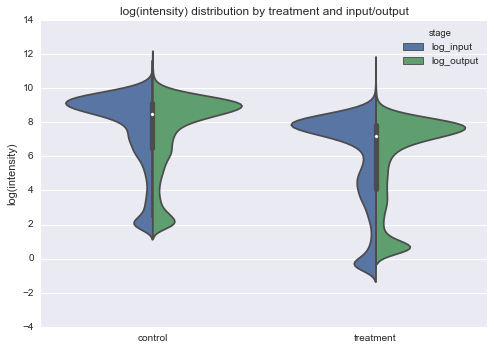

In [21]:
g = sns.violinplot(data=input_v_output, x="treatment", y="log_intensity",
                   hue="stage", split=True)
g.set_xticklabels(['control', 'treatment'])
g.set_ylabel("log(intensity)")
g.set_xlabel("")
g.set_title("log(intensity) distribution by treatment and input/output");

## Sakai vs DH10B data

We are interested only in the potential for differential representation of *E.coli* Sakai protein products, and could later remove all probes that are not expected to hybridise to *E. coli* Sakai from the dataset. We are not concerned with high-level interactions with *E. coli* DH10B genes, and may be willing later on to exclude these from the analysis.

Evidence for potential hybridisation to Sakai was determined by `BLASTX` query of each probe sequence against chromosome and plasmid amino acid sequences from the NCBI records `NC_002695`, `NC_002128` and `NC_002127`. The results of the `BLASTX` comparison are provided in the file `data/probes_blastx_sakai.tab`.

We read the data from the `data/probes_blastx_sakai.tab` file, and add a new column called `sakai`, which takes a value of `1` if the probe could hybridise to Sakai, and `0` if a `BLASTX` hit is not recorded, or a `BLASTX` hit with less than 100% identity is recorded.

In [22]:
# Read BLASTX hit data, and discard probes with less than 100% identity match
blast_hits = pd.read_csv("data/probes_blastx_sakai.tab", sep="\t",
                         names=['probe', 'match', 'identity', 'length',
                                'mismatch', 'gapopen', 'qstart', 'qend',
                                'sstart', 'send', 'evalue', 'bitscore'])
blast_hits = blast_hits.loc[blast_hits['identity'] == 100]

We add a new column to our dataset, on the basis of the `probe` column from `data` being present in `blast_hits`:

In [23]:
# Add sakai column: 1 if probe has 100% BLASTX hit, 0 otherwise
data['sakai'] = data['probe'].isin(blast_hits['probe'].values).astype(int)

## Write data

We write the normalised, long-format data to `output/normalised_array_data.tab`.

In [24]:
# Write data to file
os.makedirs("output", exist_ok=True)
data.to_csv("output/normalised_array_data.tab", sep="\t", index=False)